In [1]:
from pathlib import Path
from typing import List
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import load_workload_data as ld
import load_benchmark_data as be
import matplotlib.pyplot as plt

In [2]:
# Init
sns.set()
sns.set(rc={'figure.figsize':(2,1)})
plt.tight_layout()
workloads: Path = Path("../data/workloads/")

def plot_stacked(data: DataFrame, x: str, y: str, hue: str, hue_order: List[str]=None, order: List[str]=None, color=None):
    df_plottable: DataFrame = data.groupby([x, hue])[y].sum().reset_index().pivot(columns=hue, index=x, values=y)
    if hue_order:
        assert sorted(hue_order) == sorted(list(df_plottable))
        df_plottable = df_plottable[hue_order]
    if order:
        df_plottable = df_plottable.reindex(order)
    df_plottable.plot(kind="bar", stacked=True, ax=plt.gca(), rot=0)
    plt.ylabel(y)

def plot_workload(workload_folder: Path):
    df = ld.get_workload_data(workload_folder)
    x_order: List[str] = sorted(df[ld.DATA_TYPE].drop_duplicates(), reverse=True)
    order: List[str] = ["TABLE_SCAN", "JOIN", "AGGREGATE", "PROJECTION"]
    order_filtered = [operator for operator in order if operator in list(df[ld.OPERATOR_TYPE])]
    plot_stacked(data=df, x=ld.DATA_TYPE, y=ld.RUNTIME_S, hue=ld.OPERATOR_TYPE, hue_order=order_filtered, order=x_order)

<Figure size 144x72 with 0 Axes>

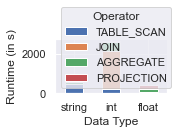

In [3]:
test = plot_workload(workloads / "TPC-H")
plt.savefig("visualizations/tpch-workload.svg", bbox_inches = "tight")

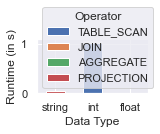

In [4]:
plot_workload(workloads / "TPC-C")

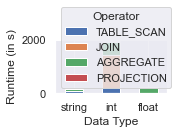

In [5]:
plot_workload(workloads / "TPC-DS")
plt.savefig("visualizations/tpcds-workload.svg", bbox_inches = "tight")

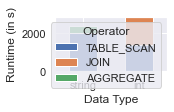

In [6]:
plot_workload(workloads / "Join Order Benchmark")
plt.savefig("visualizations/jo_workload.svg", bbox_inches = "tight")

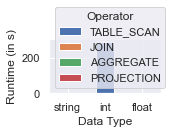

In [7]:
plot_workload(workloads / "CH-benCHmark")

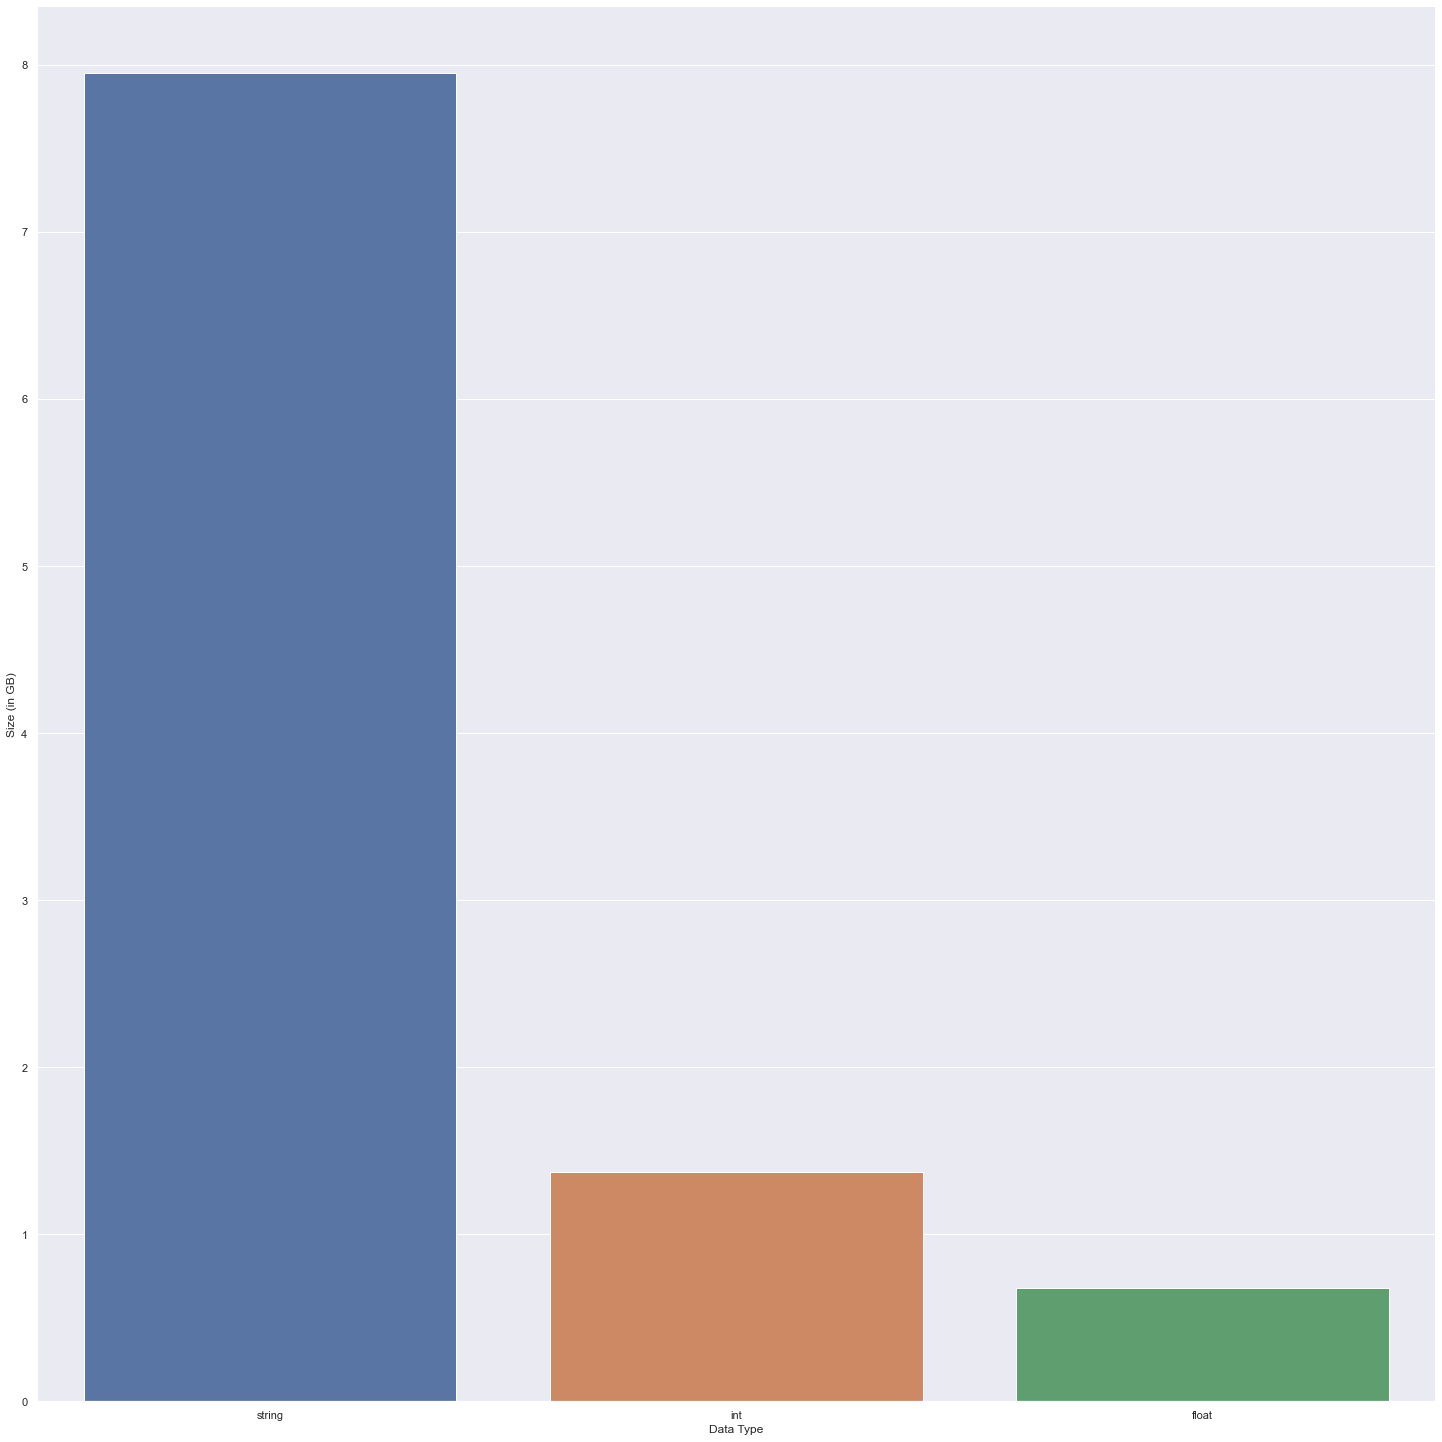

In [8]:
def plot_sizes(sizes_file: Path, benchmark_name: str):
    sizes: DataFrame = be.load_sizes(sizes_file)
    accumulated: DataFrame = sizes.groupby([be.DATA_TYPE], as_index=False)[be.SIZE_IN_GB].sum()
    x_order: List[str] = sorted(accumulated[be.DATA_TYPE], reverse=True)
    sns.catplot(data=accumulated, x=be.DATA_TYPE, y=be.SIZE_IN_GB, kind="bar", order=x_order, height=20)
    plt.savefig(f"visualizations/sizes_{benchmark_name}.svg", bbox_inches = "tight")
plot_sizes(Path("../data/nemea_TPC-H_sf10_singlethreaded/sizes_Dictionary.txt"), "tpch")

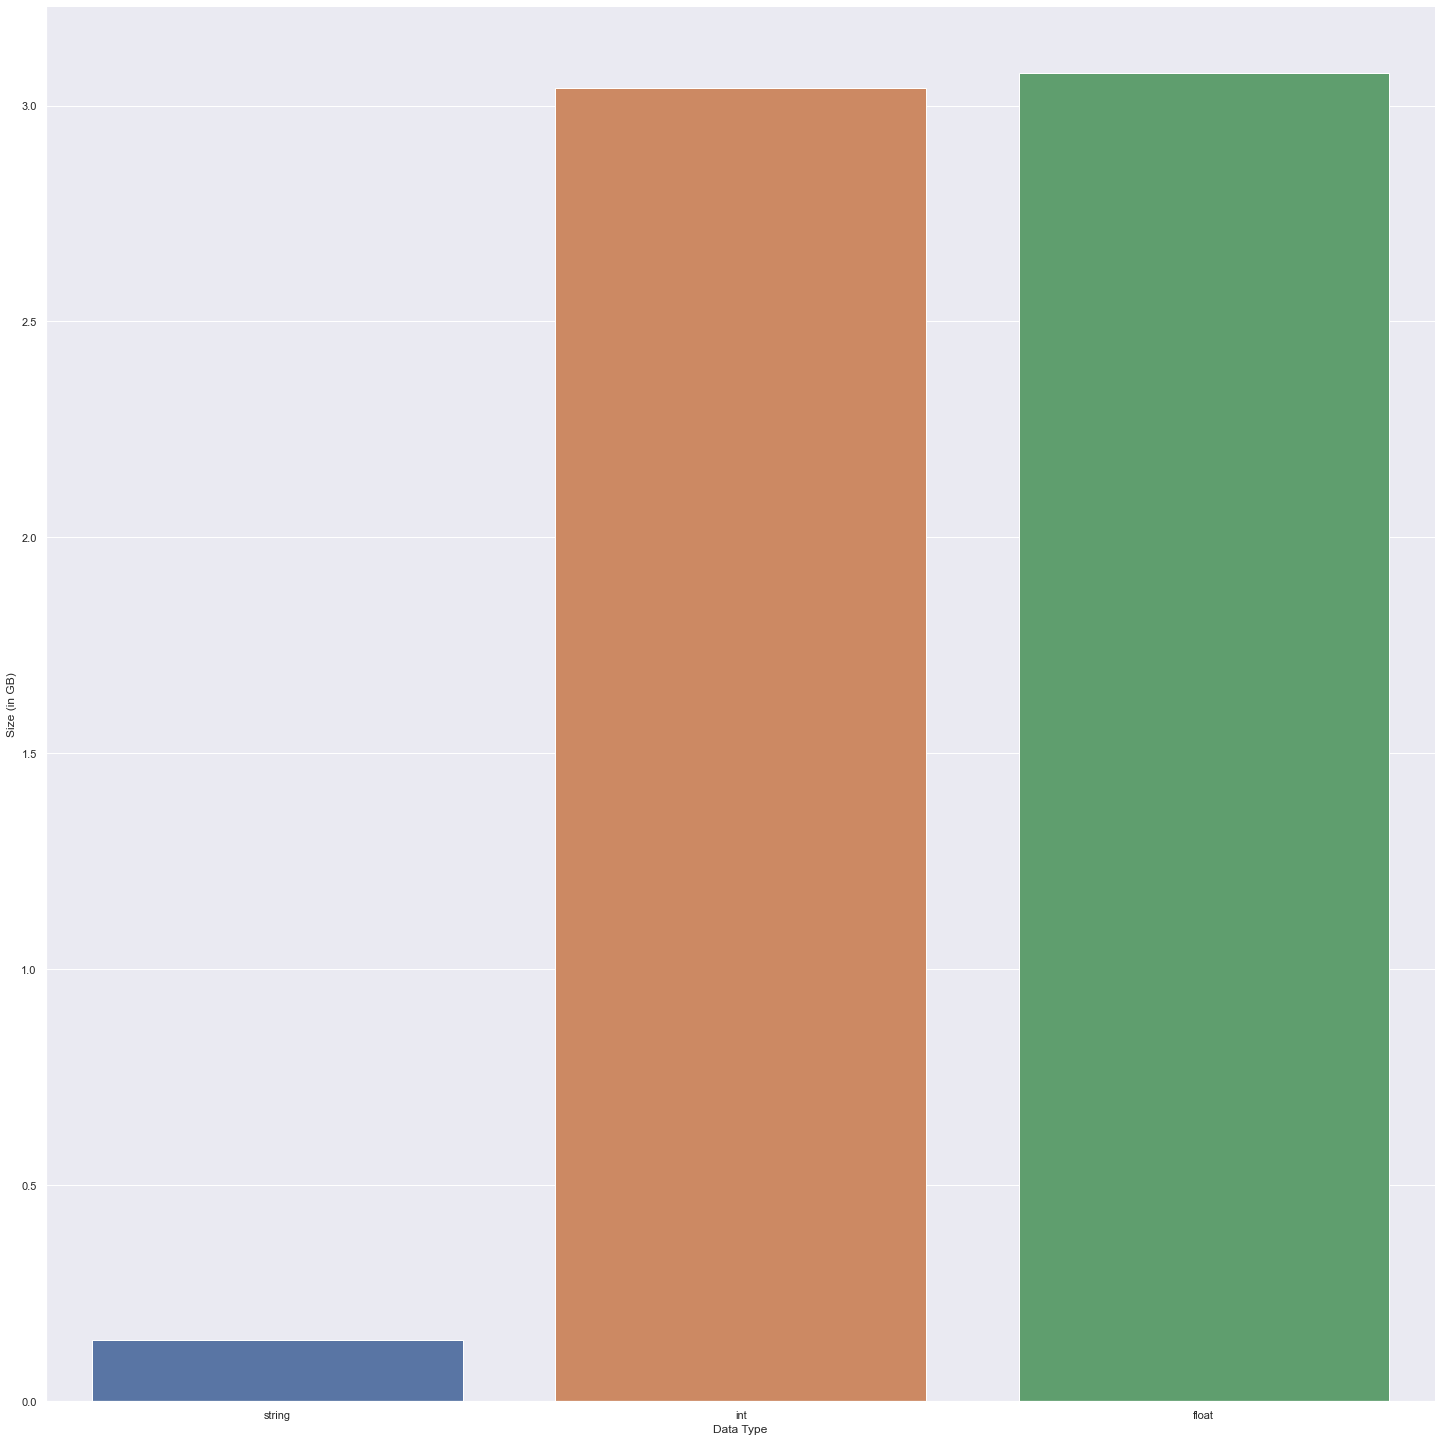

In [9]:
plot_sizes(Path("../data/nemea_TPC-DS_sf10_singlethreaded/sizes_Dictionary.txt"), "tpcds")

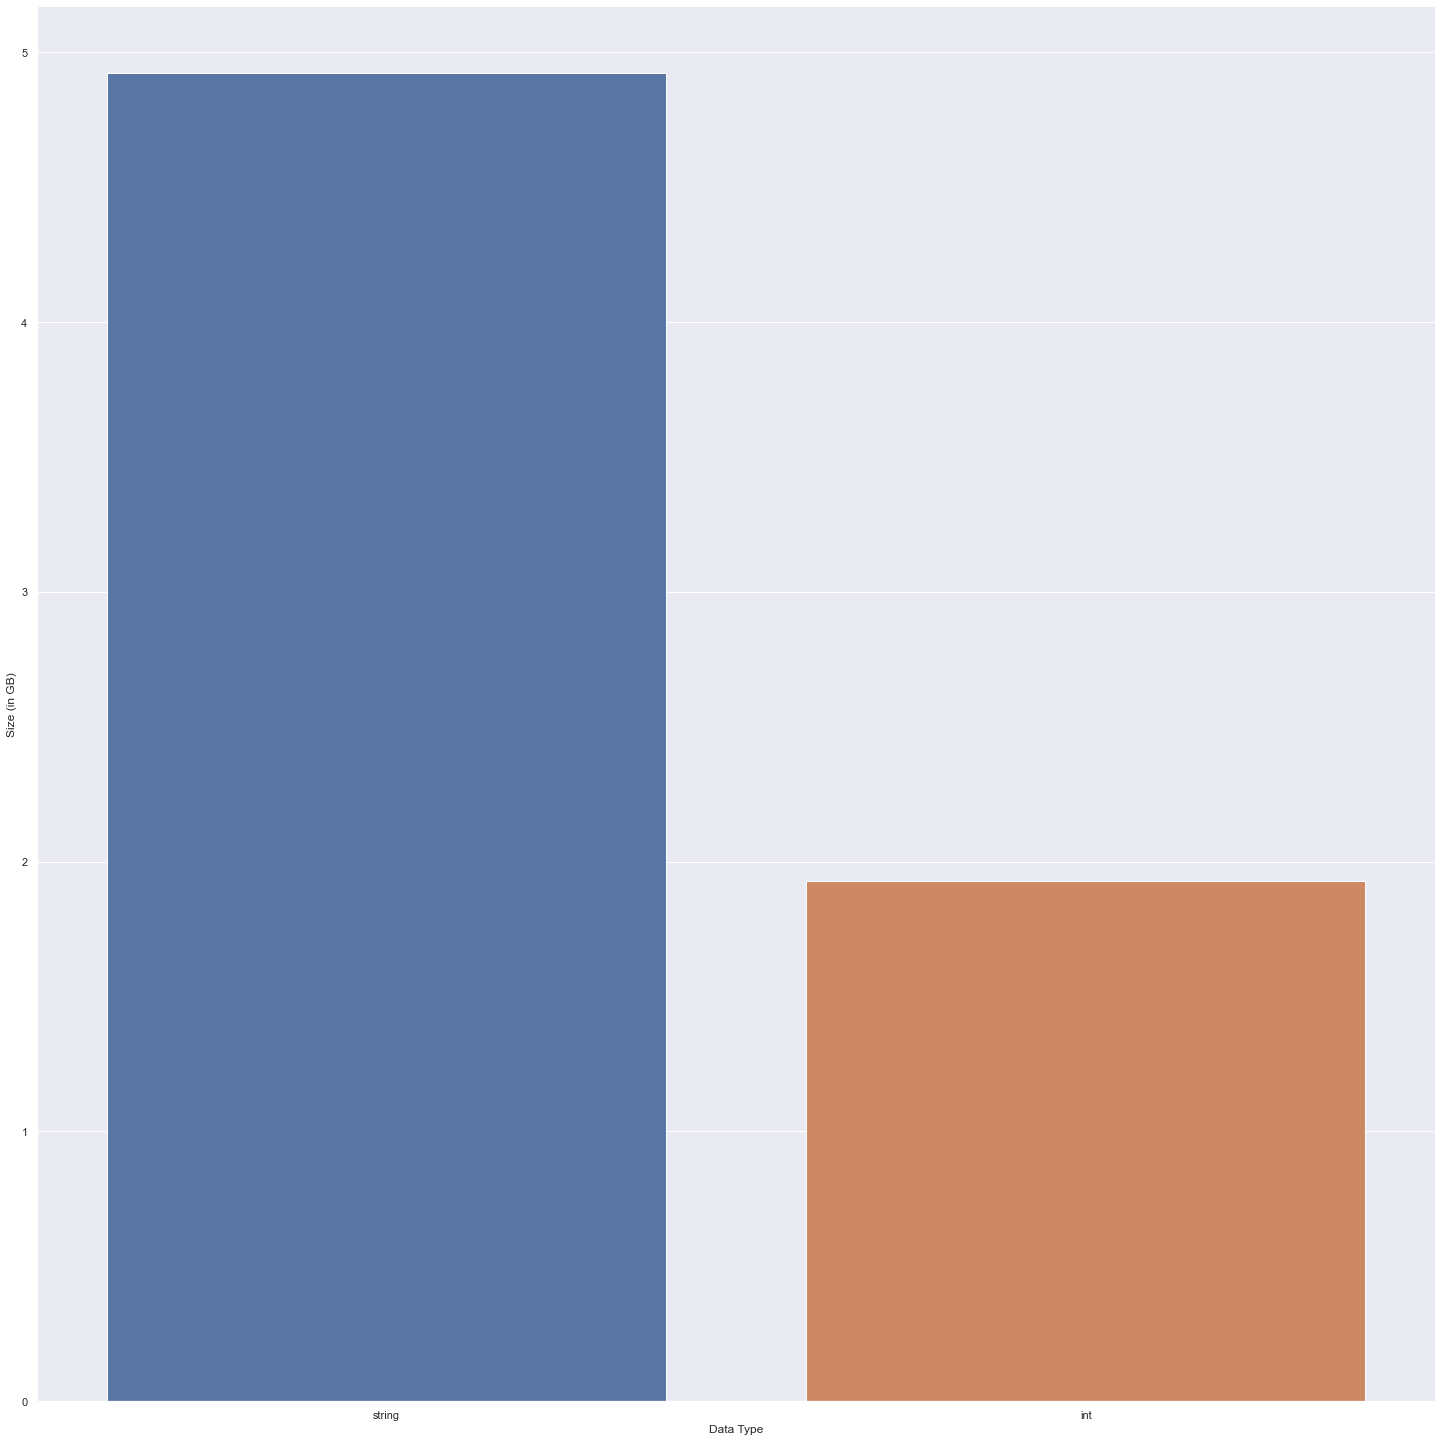

In [10]:
plot_sizes(Path("../data/nemea_JOB_sf10_singlethreaded/sizes_Dictionary.txt"), "jo")


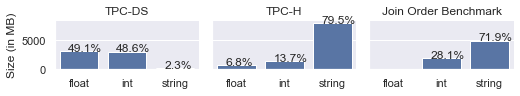

In [36]:
def without_hue(plot: sns.FacetGrid, data: DataFrame, col: str, y: str, order: List[str]):
    for i, ax in enumerate(plot.axes.flatten()):
        total: int = data[data[col] == order[i]][y].sum()
        for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_height()/total)
            x_val = p.get_x() + p.get_width() / 2 - 0.23
            y_val = p.get_y() + p.get_height()
            ax.annotate(percentage, (x_val, y_val), size = 12)

SIZE_IN_MB: str = "Size (in MB)"
tpch: DataFrame = be.load_sizes(Path("../data/nemea_TPC-H_sf10_singlethreaded/sizes_Dictionary.txt"))
tpcds: DataFrame = be.load_sizes(Path("../data/nemea_TPC-DS_sf10_singlethreaded/sizes_Dictionary.txt"))
jo: DataFrame = be.load_sizes(Path("../data/nemea_JOB_sf10_singlethreaded/sizes_Dictionary.txt"))

tpch["Benchmark"] = ["TPC-H" for i in range(0,len(tpch))]
tpcds["Benchmark"] = ["TPC-DS" for i in range(0,len(tpcds))]
jo["Benchmark"] = ["Join Order Benchmark" for i in range(0,len(jo))]
combined: DataFrame = tpch.append(tpcds).append(jo)
accumulated: DataFrame = combined.groupby([be.DATA_TYPE, "Benchmark"], as_index=False)[be.SIZE_IN_GB].sum()
accumulated[SIZE_IN_MB] = [size * 1000 for size in accumulated[be.SIZE_IN_GB]]
g = sns.catplot(data=accumulated, x=be.DATA_TYPE, y=SIZE_IN_MB, kind="bar", col="Benchmark", palette=["C0", "C0", "C0"], height=1.5, aspect=1.6)
g.set_titles(col_template="{col_name}")
g.set_xlabels("")
without_hue(g, data=accumulated, y=SIZE_IN_MB, col="Benchmark", order=["TPC-DS", "TPC-H", "Join Order Benchmark"])
plt.savefig("visualizations/sizes.svg", bbox_inches = "tight")

In [37]:
tpch_work: DataFrame = ld.get_workload_data(workloads / "TPC-H")
tpcds_work: DataFrame = ld.get_workload_data(workloads / "TPC-DS")
jo_work: DataFrame = ld.get_workload_data(workloads / "Join Order Benchmark")

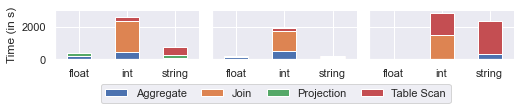

In [40]:
combined: DataFrame = tpch_work.append(tpcds_work).append(jo_work)
combined = combined.append({be.DATA_TYPE: "float", "WORKLOAD":"Join Order Benchmark", ld.RUNTIME_S:1, ld.OPERATOR_TYPE: "JOIN"}, ignore_index=True)
combined = combined.append({be.DATA_TYPE: "float", "WORKLOAD":"Join Order Benchmark", ld.RUNTIME_S: 1, ld.OPERATOR_TYPE: "TABLE_SCAN"}, ignore_index=True)
combined = combined.append({be.DATA_TYPE: "float", "WORKLOAD":"Join Order Benchmark", ld.RUNTIME_S: 1, ld.OPERATOR_TYPE: "AGGREGATE"}, ignore_index=True)
combined = combined.append({be.DATA_TYPE: "float", "WORKLOAD":"Join Order Benchmark", ld.RUNTIME_S: 1, ld.OPERATOR_TYPE: "PROJECTION"}, ignore_index=True)
combined = combined.append({be.DATA_TYPE: "int", "WORKLOAD":"Join Order Benchmark", ld.RUNTIME_S: 1, ld.OPERATOR_TYPE: "JOIN"}, ignore_index=True)
combined = combined.append({be.DATA_TYPE: "int", "WORKLOAD":"Join Order Benchmark", ld.RUNTIME_S: 1, ld.OPERATOR_TYPE: "TABLE_SCAN"}, ignore_index=True)
combined = combined.append({be.DATA_TYPE: "int", "WORKLOAD":"Join Order Benchmark", ld.RUNTIME_S: 1, ld.OPERATOR_TYPE: "AGGREGATE"}, ignore_index=True)
combined = combined.append({be.DATA_TYPE: "int", "WORKLOAD":"Join Order Benchmark", ld.RUNTIME_S: 1, ld.OPERATOR_TYPE: "PROJECTION"}, ignore_index=True)
combined = combined.append({be.DATA_TYPE: "string", "WORKLOAD":"Join Order Benchmark", ld.RUNTIME_S: 1, ld.OPERATOR_TYPE: "JOIN"}, ignore_index=True)
combined = combined.append({be.DATA_TYPE: "string", "WORKLOAD":"Join Order Benchmark", ld.RUNTIME_S: 1, ld.OPERATOR_TYPE: "TABLE_SCAN"}, ignore_index=True)
combined = combined.append({be.DATA_TYPE: "string", "WORKLOAD":"Join Order Benchmark", ld.RUNTIME_S: 1, ld.OPERATOR_TYPE: "AGGREGATE"}, ignore_index=True)
combined = combined.append({be.DATA_TYPE: "string", "WORKLOAD":"Join Order Benchmark", ld.RUNTIME_S: 1, ld.OPERATOR_TYPE: "PROJECTION"}, ignore_index=True)
combined[ld.OPERATOR_TYPE] = [operator.title().replace("_", " ") for operator in combined[ld.OPERATOR_TYPE]]
g = sns.FacetGrid(combined, col="WORKLOAD", height=1.5, aspect=1.6)
g.map_dataframe(plot_stacked, x=ld.DATA_TYPE, y=ld.RUNTIME_S, hue=ld.OPERATOR_TYPE)
g.set_titles(col_template="")
g.set_ylabels("Time (in s)")
plt.legend(bbox_to_anchor=(-1.9,-2.0,2.5,1.6), loc=2, mode="expand", ncol=4)
plt.savefig("visualizations/workload.svg", bbox_inches = "tight")

In [15]:
accumulated

,Data Type,Benchmark,Size (in GB),Size (in MB)
0,float,TPC-DS,3.075083,3075.083052
1,float,TPC-H,0.676387,676.386560
2,int,Join Order Benchmark,1.927429,1927.429163
3,int,TPC-DS,3.041191,3041.190559
4,int,TPC-H,1.372782,1372.782099
5,string,Join Order Benchmark,4.923201,4923.200842
6,string,TPC-DS,0.141697,141.697194
7,string,TPC-H,7.950671,7950.670887
